# Synthetic Brand Generation with GANs

## Project Goal
Generate synthetic brand data to address class imbalance in hierarchical clustering using:
- **CTGAN**: For generating realistic brand features (ESG metrics, demographics, business characteristics)
- **DistilGPT2**: For generating realistic brand names

## Dataset
- **Source**: `data/raw/brand_information.csv`
- **Size**: 3,605 brands with 80+ features
- **Problem**: Hierarchical clustering produces only 2 clusters (severe imbalance)

## Notebook Structure
1. **Phase 1**: Data Preparation & Exploration
2. **Phase 2**: CTGAN Training (Tabular Features)
3. **Phase 3**: Brand Name Generation (DistilGPT2)
4. **Phase 4**: Synthetic Data Generation
5. **Phase 5**: Evaluation & Clustering Comparison

## Setup & Installation

In [4]:
# Install required packages (run once in Colab)
#!git clone https://github.com/dyegofern/csca5642-deep-learning
#!pip install -q sdv transformers torch pandas numpy scikit-learn matplotlib seaborn plotly scipy

In [5]:
import sys
import os
MAPPED_DIR = '/content/csca5642-deep-learning' # Corrected to absolute path

# Add src to path (for local imports)
src_path = MAPPED_DIR + '/src'
if src_path not in sys.path:
    sys.path.append(src_path)

# Add data to path (for local imports) - as specified by the user
data_path = MAPPED_DIR + '/data'
if data_path not in sys.path:
    sys.path.append(data_path)

# Import our custom modules
from data_processor import BrandDataProcessor
from tabular_gan import TabularBrandGAN
from brand_name_generator import BrandNameGenerator
from evaluator import BrandDataEvaluator

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All modules loaded successfully!")

All modules loaded successfully!


## Configuration

In [6]:
# Paths (adjust for Colab if needed)
DATA_PATH = os.path.join(MAPPED_DIR, 'data', 'raw', 'brand_information.csv')
OUTPUT_DIR = os.path.join(MAPPED_DIR, 'data', 'generated')
MODEL_DIR = os.path.join(MAPPED_DIR, 'models')

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Training parameters
CTGAN_EPOCHS = 300
CTGAN_BATCH_SIZE = 500
GPT2_EPOCHS = 3
GPT2_BATCH_SIZE = 8

# Generation parameters
N_SYNTHETIC_BRANDS = 500  # Total synthetic brands to generate
MIN_BRANDS_PER_COMPANY = 3  # Minimum brands a company should have

print(f"Data path: {DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Data path: /content/csca5642-deep-learning/data/raw/brand_information.csv
Output directory: /content/csca5642-deep-learning/data/generated
Model directory: /content/csca5642-deep-learning/models


---
# Phase 1: Data Preparation & Exploration

Load and explore the brand dataset, then prepare it for GAN training.

## 1.1 Load Data

In [7]:
# Initialize data processor
processor = BrandDataProcessor(DATA_PATH)

# Load data
df = processor.load_data()
df.head()

Loading data from /content/csca5642-deep-learning/data/raw/brand_information.csv...
Loaded 3605 brands with 77 features


,industry_id,industry_name,deforestation_risk,labor_exploitation_risk,chemical_pollution_risk,supply_chain_greenwashing_risk,positive_innovation_risk,esg_summary,company_id,company_name,...,supply_chain_localization,product_portfolio_diversity,revenue_billion_usd,customer_loyalty_index,r_and_d_spend_percent_revenue,women_board_percent,ceo_tenure_years,market_cap_billion_usd,major_sustainability_award_last5y,references_and_links
0,10,Household & Personal Products,1,1,1,0,0,Household & Personal Products industry demonst...,125,"S. C. Johnson & Son, Inc.",...,85,2,0.04,55,0.5,20,3,0.0,0,https://www.galaxus.ch; Limited English sources
1,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,51,Ferrero Group,...,40,1,0.18,65,0.8,25,2,0.0,0,https://en.wikipedia.org/wiki/100_Grand_Bar
2,17,"Meat, Poultry & Dairy",1,1,1,0,0,"Meat, Poultry & Dairy industry faces severe ES...",96,Foremost Farms USA Cooperative,...,90,1,0.02,70,0.1,15,4,0.0,0,https://www.foremostfarms.com/foremost-farms-a...
3,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,95,"Wells Enterprises, Inc.",...,70,2,0.03,72,0.5,20,3,0.0,0,http://www.onsecondscoop.com/2014/04/2nd-st-cr...
4,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,10,"Mars, Incorporated",...,45,1,0.25,72,0.8,25,3,0.0,0,https://www.businessinsider.com/mars-inc-famil...


## 1.2 Exploratory Data Analysis


=== Data Exploration ===
Total brands: 3605
Total features: 77

Top 10 companies by brand count:
  Nestle: 126 brands
  Bayer: 95 brands
  Conagra Brands Inc.: 94 brands
  Hershey Company: 79 brands
  General Mills: 75 brands
  JBS USA: 74 brands
  PepsiCo, Inc.: 69 brands
  Ferrero Group: 69 brands
  Ajinomoto: 62 brands
  Target: 58 brands


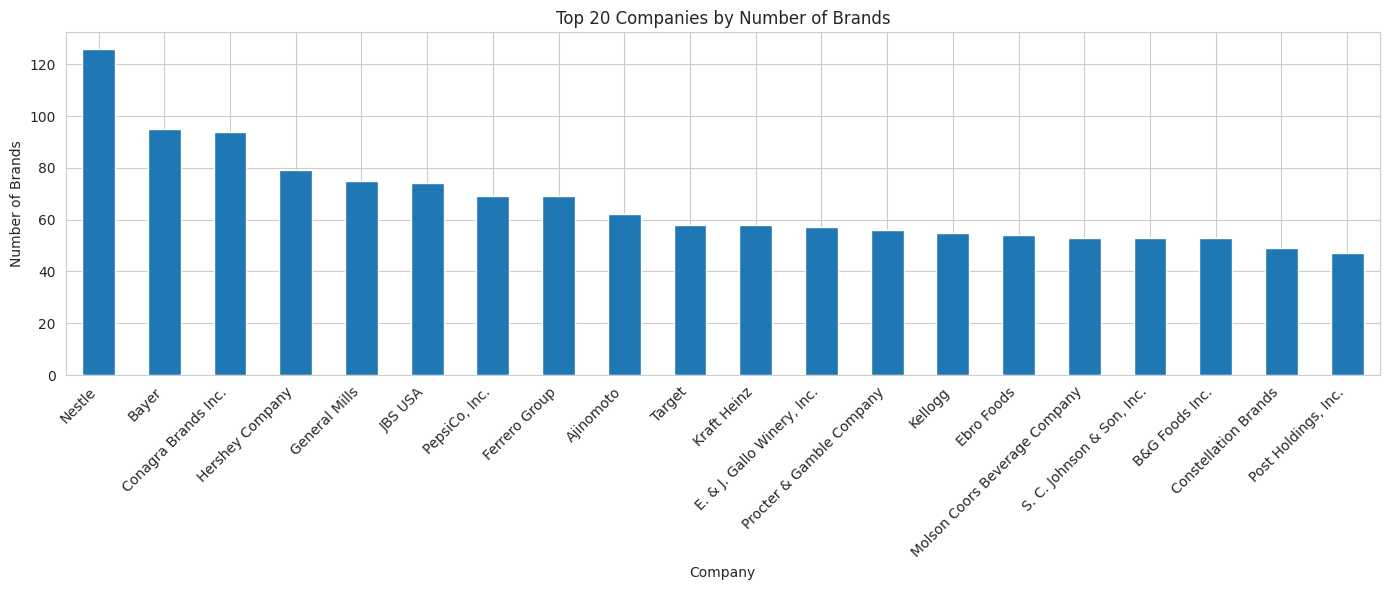


Companies with 1 brand: 40
Companies with 2+ brands: 203
Companies with 5+ brands: 153


In [8]:
# Explore the dataset
stats = processor.explore_data()

# Visualize brands per company
brand_counts = pd.Series(stats['brands_per_company'])
top_companies = brand_counts.head(20)

plt.figure(figsize=(14, 6))
top_companies.plot(kind='bar')
plt.title('Top 20 Companies by Number of Brands')
plt.xlabel('Company')
plt.ylabel('Number of Brands')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nCompanies with 1 brand: {(brand_counts == 1).sum()}")
print(f"Companies with 2+ brands: {(brand_counts >= 2).sum()}")
print(f"Companies with 5+ brands: {(brand_counts >= 5).sum()}")

In [9]:
# Identify multi-brand companies (good for training)
multi_brand_companies = processor.get_multi_brand_companies(min_brands=3)

print(f"\nIdentified {len(multi_brand_companies)} companies with 3+ brands")
print("\nExample companies:")
for company in multi_brand_companies[:10]:
    n_brands = len(processor.get_company_brands(company))
    print(f"  {company}: {n_brands} brands")


Found 186 companies with 3+ brands

Identified 186 companies with 3+ brands

Example companies:
  Nestle: 126 brands
  Bayer: 95 brands
  Conagra Brands Inc.: 94 brands
  Hershey Company: 79 brands
  General Mills: 75 brands
  JBS USA: 74 brands
  PepsiCo, Inc.: 69 brands
  Ferrero Group: 69 brands
  Ajinomoto: 62 brands
  Target: 58 brands


## 1.3 Data Cleaning & Preprocessing

In [10]:
# Clean the data
df_clean = processor.clean_data(drop_text_heavy=True)

# Check for missing values
missing = df_clean.isnull().sum()
print(f"\nRemaining missing values: {missing[missing > 0]}")


=== Data Cleaning ===

Identified 54 numerical features
Identified 7 categorical features
Identified 6 text features (will be handled separately)
Dropped text-heavy columns: ['esg_summary', 'accusation', 'references_and_links']

Handling missing values...
  Filled demographics_gender with mode/Unknown
  Filled demographics_lifestyle with mode/Unknown

Cleaned dataset: 3605 rows, 74 columns

Remaining missing values: fossil_fuel_reliance      146
esg_programs              146
sustainability_actions    146
target_population         146
main_partnerships         146
dtype: int64


In [ ]:
# Prepare data for GAN training
train_df, val_df = processor.prepare_for_gan(test_size=0.2)

print(f"\nTraining set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"\nFeatures for GAN: {list(train_df.columns)}")

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Necessary if encoding is re-applied here
import pandas as pd # Ensure pandas is imported within the function if not globally available in this scope

def new_prepare_for_gan(self, test_size=0.2):
    print("=== Preparing Data for GAN (Modified for Stratification) ===")

    # Ensure df_clean is available and copy it for processing
    if self.df_clean is None:
        raise ValueError("df_clean is not available. Please load and clean data first.")
    df_gan = self.df_clean.copy()

    # Re-apply Label Encoding as in the original method
    self.label_encoders = {} # Re-initialize label encoders for this run

    print("\nEncoding categorical features...")
    # Ensure categorical_features are identified (they should be from init/clean_data)
    if not hasattr(self, 'categorical_features') or not self.categorical_features:
        # Fallback or error if categorical_features were not set previously
        # For this context, assuming they are set by an earlier clean_data call.
        raise AttributeError("Categorical features not identified. Run clean_data first.")

    for col in self.categorical_features:
        le = LabelEncoder()
        df_gan[col] = le.fit_transform(df_gan[col])
        self.label_encoders[col] = le
        print(f"  Encoded {col}: {len(le.classes_)} unique values")

    # Also encode company_name for stratification
    le_company = LabelEncoder()
    df_gan['company_name'] = le_company.fit_transform(df_gan['company_name'])
    self.label_encoders['company_name'] = le_company
    print(f"  Encoded company_name: {len(le_company.classes_)} companies")

    # Identify companies with only one brand (after encoding)
    company_counts = df_gan['company_name'].value_counts()
    single_brand_company_ids = company_counts[company_counts == 1].index

    # Separate single-brand companies from multi-brand companies
    df_single_brand = df_gan[df_gan['company_name'].isin(single_brand_company_ids)]
    df_multi_brand = df_gan[~df_gan['company_name'].isin(single_brand_company_ids)]

    train_df = pd.DataFrame(columns=df_gan.columns)
    val_df = pd.DataFrame(columns=df_gan.columns)

    if not df_multi_brand.empty:
        # Perform stratified split on multi-brand companies
        train_multi, val_multi = train_test_split(
            df_multi_brand,
            test_size=test_size,
            random_state=42,
            stratify=df_multi_brand['company_name']
        )
        train_df = pd.concat([train_df, train_multi], ignore_index=True)
        val_df = pd.concat([val_df, val_multi], ignore_index=True)
    else:
        print("No multi-brand companies for stratified split.")

    # Add single-brand companies to the training set
    if not df_single_brand.empty:
        train_df = pd.concat([train_df, df_single_brand], ignore_index=True)
        print(f"Added {len(df_single_brand)} single-brand examples to the training set.")
    else:
        print("No single-brand companies to add.")

    # Shuffle the combined training set for good measure
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    self.train_features = list(train_df.columns) # Update train_features

    return train_df, val_df

# Override the prepare_for_gan method of the processor instance
processor.prepare_for_gan = new_prepare_for_gan.__get__(processor, BrandDataProcessor)

print("processor.prepare_for_gan method has been overridden.")

processor.prepare_for_gan method has been overridden.


---
# Phase 2: CTGAN Training (Tabular Features)

Train CTGAN to generate realistic brand features conditioned on company name.

In [14]:
# Initialize CTGAN
ctgan = TabularBrandGAN(
    epochs=CTGAN_EPOCHS,
    batch_size=CTGAN_BATCH_SIZE,
    verbose=True
)

# Identify discrete columns (categorical features that were encoded)
discrete_cols = processor.categorical_features + ['company_name']
discrete_cols = [col for col in discrete_cols if col in train_df.columns]

print(f"Discrete columns for CTGAN: {discrete_cols}")

Discrete columns for CTGAN: ['industry_name', 'country_of_origin', 'headquarters_country', 'demographics_income_level', 'demographics_geographic_reach', 'demographics_gender', 'demographics_lifestyle', 'company_name']


In [15]:
# Train CTGAN (this may take 10-30 minutes depending on GPU)
ctgan.train(train_df, discrete_columns=discrete_cols)


=== Training CTGAN ===
Training on 2892 samples with 74 features
Training for 300 epochs with batch size 500...
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name               Est # of Columns (CTGAN)
industry_name                      11
deforestation_risk                 2
labor_exploitation_risk            2
chemical_pollution_risk            2
supply_chain_greenwashing_risk     2
positive_innovation_risk           2
company_name                       11
scope_v_revenues                   11
reported_scope                     2
emissions_rank                     11
in_industry_rank                   11
global_rank                        11
exclusions                         2
initial_greenwashing_level         11
greenwashing_factor_1              11
greenwashing_factor_2              11
greenwashing_factor_3              11
greenwashing_factor_4              11
reve

Gen. (-0.41) | Discrim. (-1.49): 100%|██████████| 300/300 [07:23<00:00,  1.48s/it]

Training completed!


In [16]:
# Save the trained model
ctgan_model_path = os.path.join(MODEL_DIR, 'ctgan_brand_model.pkl')
ctgan.save_model(ctgan_model_path)

Model saved to /content/csca5642-deep-learning/models/ctgan_brand_model.pkl


## 2.2 Test CTGAN Generation

In [23]:
from sdv.single_table.base import Condition # Import the Condition class

# Test: Generate 5 synthetic brands for a specific company
test_company = multi_brand_companies[0]
test_company_encoded = processor.label_encoders['company_name'].transform([test_company])[0]

print(f"Testing generation for: {test_company} (encoded: {test_company_encoded})")

# Define a workaround generate function to avoid the sdv bug
def generate_workaround(self, n_samples, condition_column=None, condition_value=None):
    print(f"=== Generating {n_samples} Synthetic Brands (Workaround) ===")
    synthetic_data = pd.DataFrame()
    if condition_column and condition_value is not None:
        print(f"Conditioning on {condition_column} = {condition_value}")

        for _ in range(n_samples):
            # Create a dictionary of conditions for the Condition object
            conditions_dict = {condition_column: condition_value}
            # Create a single Condition object with num_rows=1
            condition_obj = Condition(conditions_dict, num_rows=1)
            conditions_list = [condition_obj] # Pass it as a list of Condition objects

            sampled_row = self.model.sample_from_conditions(
                conditions=conditions_list,
                max_tries_per_batch=1000 # Increase the number of tries
            )
            synthetic_data = pd.concat([synthetic_data, sampled_row], ignore_index=True)
    else:
        synthetic_data = self.model.sample(n_samples)
    return synthetic_data

# Replace the original generate method with the workaround
ctgan.generate = generate_workaround.__get__(ctgan, type(ctgan))

# Now call the modified generate method
test_synthetic = ctgan.generate(
    n_samples=5,
    condition_column='company_name',
    condition_value=test_company_encoded
)

# Decode and display
test_decoded = processor.decode_categorical(test_synthetic)
test_decoded.head()

Testing generation for: Nestle (encoded: 156)
=== Generating 5 Synthetic Brands (Workaround) ===
Conditioning on company_name = 156


Sampling conditions: 100%|██████████| 1/1 [06:01<00:00, 361.71s/it]


,industry_id,industry_name,deforestation_risk,labor_exploitation_risk,chemical_pollution_risk,supply_chain_greenwashing_risk,positive_innovation_risk,company_id,company_name,scope_v_revenues,...,branding_innovation_level,supply_chain_localization,product_portfolio_diversity,revenue_billion_usd,customer_loyalty_index,r_and_d_spend_percent_revenue,women_board_percent,ceo_tenure_years,market_cap_billion_usd,major_sustainability_award_last5y
0,6,Multiline and Specialty Retailers & Distributors,1,1,1,0,0,23,Nestle,0.0000,...,2,70.0,2,0.0000,0.0,0.6,25.0,2,0.03,0
1,6,Household & Personal Products,1,1,1,0,1,152,Nestle,19.8020,...,0,48.0,2,0.4660,70.0,0.3,18.0,3,0.13,0
2,10,Non-Alcoholic Beverages,1,1,0,0,0,127,Nestle,26.3897,...,0,0.0,8,4.0259,90.0,0.8,32.0,2,0.56,0
3,7,Agricultural Products,0,0,1,0,0,1,Nestle,18.0776,...,1,60.0,2,0.0000,70.0,0.1,25.0,3,0.00,0
4,1,E-commerce,0,1,1,1,1,139,Nestle,11.2881,...,1,60.0,2,0.0098,80.0,1.0,25.0,2,0.00,0


---
# Phase 3: Brand Name Generation (DistilGPT2)

Fine-tune DistilGPT2 to generate realistic brand names.

## 3.1 Prepare Brand Name Training Data

In [ ]:
# Test: Generate 5 synthetic brands for a specific company
test_company = multi_brand_companies[0]
test_company_encoded = processor.label_encoders['company_name'].transform([test_company])[0]

print(f"Testing generation for: {test_company} (encoded: {test_company_encoded})")

# Now use the fixed generate method from the class
test_synthetic = ctgan.generate(
    n_samples=5,
    condition_column='company_name',
    condition_value=test_company_encoded
)

# Decode and display
test_decoded = processor.decode_categorical(test_synthetic)
test_decoded.head()

## 3.2 Fine-tune DistilGPT2

In [25]:
# Initialize brand name generator
name_generator = BrandNameGenerator(model_name='distilgpt2')

# Prepare model
name_generator.prepare_model()

Using device: cuda

Loading distilgpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on cuda


In [26]:
# Fine-tune on brand names (this may take 15-30 minutes)
gpt2_output_dir = os.path.join(MODEL_DIR, 'brand_name_generator')

name_generator.fine_tune(
    brands_df=brand_name_df,
    epochs=GPT2_EPOCHS,
    batch_size=GPT2_BATCH_SIZE,
    output_dir=gpt2_output_dir
)


=== Fine-tuning Brand Name Generator ===
Training on 3605 brand examples
Training for 3 epochs...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dyegofern (dyegofern-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,2.648000
100,1.769700
150,1.631000
200,1.494000
250,1.452200
300,1.361500
350,1.394700
400,1.270400
450,1.290700
500,1.166500


Fine-tuning completed!
Model saved to /content/csca5642-deep-learning/models/brand_name_generator


## 3.3 Test Brand Name Generation

In [27]:
# Test: Generate brand names for different companies
test_companies = [
    ('PepsiCo, Inc.', 'Non-Alcoholic Beverages'),
    ('Mars, Incorporated', 'Processed Foods'),
    ('Nestle', 'Processed Foods')
]

for company, industry in test_companies:
    print(f"\n{'='*60}")
    print(f"Company: {company}")
    print(f"Industry: {industry}")
    print(f"{'='*60}")

    generated_names = name_generator.generate_brand_names(
        company_name=company,
        industry_name=industry,
        n_names=10,
        temperature=0.8
    )

    print("\nGenerated brand names:")
    for i, name in enumerate(generated_names, 1):
        print(f"  {i}. {name}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Company: PepsiCo, Inc.
Industry: Non-Alcoholic Beverages

Generating 10 brand names for PepsiCo, Inc....
Generated 9 unique names: ['Miller Lite Specialty Blend Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy', 'Mountain Dew Whipped Creamery', 'D&T Coffee Cupcake Mixer Premium Coffee Cupcake Mixer Premium Coffee Cupcake Mixer Premium Coffee Cupcake Mixer Premium Coffee Cupcake', "Mountain Jack's Pizza Company BBQs & Chex Mixins BBQ Sauce & Popcorn Recipe Mixing Season with Cheese!", 'Ice Cream Ice Creamed with Strawberry Cream Stout Creamery Specialty Pale Ale by Specialty Specialty Pale Ale by Specialty Specialty Pale Ale by', "Bimbo Gutsman's Gutsmen Gutsmen Gutsmen Gutsmen Gutsmen Gutsmen Gutsmen Guts", 'Sun Apronita Premium Premium Premium Premium Premium Premium Premium Premium Premium Premium', 'Whiskers Snacks Soda Pop! Cookies Cookies (', 'Blue Ribbon Premium Brands, Sweet Spo

---
# Phase 4: Synthetic Data Generation

Generate synthetic brands combining CTGAN features + DistilGPT2 names.

## 4.1 Determine Which Companies Need More Brands

In [28]:
# Analyze current brand distribution
brand_counts = df['company_name'].value_counts()

# Identify companies with few brands (candidates for augmentation)
companies_needing_brands = brand_counts[brand_counts < MIN_BRANDS_PER_COMPANY].index.tolist()

print(f"Companies with < {MIN_BRANDS_PER_COMPANY} brands: {len(companies_needing_brands)}")
print(f"\nWe'll generate synthetic brands for {min(50, len(companies_needing_brands))} companies")

# Select top companies to augment (balance between small and medium-sized)
target_companies = companies_needing_brands[:50]
brands_per_company = max(2, N_SYNTHETIC_BRANDS // len(target_companies))

Companies with < 3 brands: 57

We'll generate synthetic brands for 50 companies


## 4.2 Generate Synthetic Brand Features (CTGAN)

In [ ]:
# Encode target companies
target_companies_encoded = [
    processor.label_encoders['company_name'].transform([comp])[0]
    for comp in target_companies
]

# Generate synthetic features for each company
synthetic_features = ctgan.generate_for_companies(
    companies=target_companies_encoded,
    n_per_company=brands_per_company
)

print(f"\nGenerated {len(synthetic_features)} synthetic brand feature sets")
synthetic_features.head()


Generating 10 brands for 78...
=== Generating 10 Synthetic Brands (Workaround) ===
Conditioning on company_name = 78


Sampling conditions: 100%|██████████| 1/1 [01:53<00:00, 113.85s/it]



Generating 10 brands for 211...
=== Generating 10 Synthetic Brands (Workaround) ===
Conditioning on company_name = 211


Sampling conditions: 100%|██████████| 1/1 [00:22<00:00, 22.66s/it]



Generating 10 brands for 187...
=== Generating 10 Synthetic Brands (Workaround) ===
Conditioning on company_name = 187


Sampling conditions:   0%|          | 0/1 [00:00<?, ?it/s]

## 4.3 Generate Brand Names for Synthetic Data

In [ ]:
# Decode categorical features first (so we have company/industry names for generation)
synthetic_decoded = processor.decode_categorical(synthetic_features.copy())

# Generate brand names
print("\nGenerating brand names for synthetic data...")
synthetic_with_names = name_generator.generate_for_dataframe(
    synthetic_df=synthetic_decoded,
    n_names_per_brand=3,
    temperature=0.8
)

print("\nSample synthetic brands:")
synthetic_with_names[['brand_name', 'company_name', 'industry_name']].head(20)

## 4.4 Save Synthetic Data

In [ ]:
# Save synthetic brands
synthetic_path = os.path.join(OUTPUT_DIR, 'synthetic_brands.csv')
synthetic_with_names.to_csv(synthetic_path, index=False)
print(f"Synthetic brands saved to: {synthetic_path}")

# Create augmented dataset (original + synthetic)
augmented_df = pd.concat([df_clean, synthetic_with_names], ignore_index=True)
augmented_path = os.path.join(OUTPUT_DIR, 'augmented_brands.csv')
augmented_df.to_csv(augmented_path, index=False)

print(f"\nAugmented dataset saved to: {augmented_path}")
print(f"Original brands: {len(df_clean)}")
print(f"Synthetic brands: {len(synthetic_with_names)}")
print(f"Total augmented: {len(augmented_df)}")

---
# Phase 5: Evaluation & Clustering Comparison

Evaluate synthetic data quality and compare clustering results.

## 5.1 Statistical Validation

In [ ]:
# Initialize evaluator
evaluator = BrandDataEvaluator()

# Compare distributions (using numerical features)
numerical_cols = processor.numerical_features[:10]  # Sample of numerical features

ks_results = evaluator.compare_distributions(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)

In [ ]:
# Compare correlations
real_corr, synth_corr = evaluator.compare_correlations(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)

In [ ]:
# Visualize distribution comparisons
evaluator.plot_distribution_comparison(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    features=numerical_cols[:6]
)

In [ ]:
# Visualize correlation heatmaps
evaluator.plot_correlation_heatmaps(real_corr, synth_corr)

## 5.2 PCA Visualization

In [ ]:
# PCA comparison
evaluator.plot_pca_comparison(
    original_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)

## 5.3 Clustering Comparison (Main Goal)

In [ ]:
# Compare clustering: Original vs Augmented
clustering_comparison = evaluator.compare_clustering(
    original_data=df_clean,
    augmented_data=augmented_df,
    numerical_cols=numerical_cols
)

In [ ]:
# Visualize cluster distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original clustering
orig_dist = clustering_comparison['original']['cluster_distribution']
ax1.bar(orig_dist.keys(), orig_dist.values())
ax1.set_title('Original Data: Cluster Sizes')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Brands')

# Augmented clustering
aug_dist = clustering_comparison['augmented']['cluster_distribution']
ax2.bar(aug_dist.keys(), aug_dist.values())
ax2.set_title('Augmented Data: Cluster Sizes')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Brands')

plt.tight_layout()
plt.show()

## 5.4 Generate Final Report

In [ ]:
# Generate and display report
report = evaluator.generate_report()
print(report)

# Save report
report_path = os.path.join(OUTPUT_DIR, 'evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
print(f"\nReport saved to: {report_path}")

---
# Summary & Conclusions

In [ ]:
print("="*70)
print("SYNTHETIC BRAND GENERATION: FINAL SUMMARY")
print("="*70)
print(f"\n📊 Dataset Statistics:")
print(f"  Original brands: {len(df_clean)}")
print(f"  Synthetic brands generated: {len(synthetic_with_names)}")
print(f"  Augmented dataset total: {len(augmented_df)}")
print(f"  Augmentation ratio: {len(synthetic_with_names)/len(df_clean)*100:.1f}%")

print(f"\n🎯 Clustering Results:")
orig = clustering_comparison['original']
aug = clustering_comparison['augmented']
print(f"  Original - Clusters: {orig['n_clusters']}, Silhouette: {orig['silhouette_score']:.4f}")
print(f"  Augmented - Clusters: {aug['n_clusters']}, Silhouette: {aug['silhouette_score']:.4f}")
print(f"  Improvement: {clustering_comparison['silhouette_improvement']:+.4f}")

print(f"\n📁 Output Files:")
print(f"  Synthetic brands: {synthetic_path}")
print(f"  Augmented dataset: {augmented_path}")
print(f"  CTGAN model: {ctgan_model_path}")
print(f"  Name generator: {gpt2_output_dir}")
print(f"  Evaluation report: {report_path}")

print("\n✅ Pipeline completed successfully!")
print("="*70)

---
## Optional: Load Pre-trained Models

If you want to skip training and load previously saved models:

In [ ]:
# Load CTGAN model
# ctgan = TabularBrandGAN()
# ctgan.load_model(ctgan_model_path)

# Load brand name generator
# name_generator = BrandNameGenerator()
# name_generator.load_model(gpt2_output_dir)